# DEPENDENCIES

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import multiprocessing
import tqdm
from copy import copy
import sys
from cdo import Cdo
cdo = Cdo()
cdo.cleanTempDir()

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## get fair
from fair import *

## plotting functions for notebooks
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sn
sn.set_context("paper",font_scale=1.2)

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# SET ARGUMENTS

In [2]:
outdir = "/network/group/aopp/predict/AWH012_LEACH_NASTORM/IC-PREP/output/"

# IMPORT DATA

In [3]:
t3d = xr.open_dataarray(outdir+'tmp/t3d_hybrid.nc')
t2d = xr.open_dataarray(outdir+'tmp/t2d_remap.nc')
sic = xr.open_dataarray(outdir+'tmp/sic_remap.nc')
sit = xr.open_dataarray(outdir+'tmp/sit_remap.nc')

## lsm
ORCA025Z75 = xr.open_dataset('/network/group/aopp/predict/AWH012_LEACH_NASTORM/IC-PREP/source/si/mesh_mask.nc').tmask

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
libffi.so.7: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Need AWI for scaling:

In [5]:
## HadCRUT5
HC5 = xr.open_dataset('../../Ancil/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
HC5 = HC5.tas_mean.to_pandas()
HC5.index = HC5.index.year

## ERF components from AR6
erf_ar6 = pd.read_csv('../../Ancil/AR6_ERF_1750-2019.csv',index_col=0)
erf_ar6.loc[:,'ghg'] = erf_ar6.loc[:,'total_anthropogenic'] - erf_ar6.loc[:,'aerosol']
### extend ERF to 2022
ssp245_erf = pd.read_csv('../../Ancil/ERF_ssp245_1750-2500.csv',index_col=0)
ssp245_erf['aerosol'] = ssp245_erf.loc[:,'aerosol-radiation_interactions'] + ssp245_erf.loc[:,'aerosol-cloud_interactions']
ssp245_erf.loc[:,'ghg'] = ssp245_erf.loc[:,'total_anthropogenic'] - ssp245_erf.loc[:,'aerosol']
for year in [2020,2021,2022]:
    erf_ar6.loc[year] = ssp245_erf.loc[year] * erf_ar6.loc[year-1] / ssp245_erf.loc[year-1]

# COMPUTE AWI:

## ant / nat FaIR run
fair_erf = pd.DataFrame(index=erf_ar6.index,columns=pd.MultiIndex.from_product([['ant','aer','nat'],['forcing']]),data=pd.concat([erf_ar6.loc[:,'ghg'],erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'total_natural']],axis=1).values)
fair_emms = return_empty_emissions(start_year=1750,end_year=2022,scen_names=['ant','aer','nat'])
fair_temps = run_FaIR(emissions_in=fair_emms,forcing_in=fair_erf)['T'].loc[1850:]

## regress HadCRUT5 onto FaIR temperature output & define anthropogenic warming index
X = np.column_stack([np.ones(fair_temps.loc[:2021].index.size),fair_temps.loc[:2021]])
Y = HC5.loc[1850:2021].values[:,None]
mlr = OLSE.multiple(Y)
mlr.fit(X)
AWI = ( mlr.B[1]*fair_temps.aer + mlr.B[2]*fair_temps.ant ).default

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 272/272 [00:00<00:00, 1653.95 timestep/s]


# PLOTS

Global warming SST pattern (1875-2022)

In [6]:
sst_pattern = xr.open_dataarray(cdo.remapbil('r720x360',input=outdir+'tmp/t2d_remap.nc')).squeeze()

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


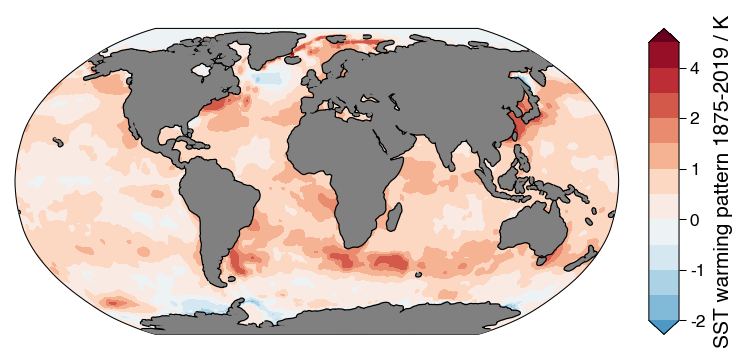

In [7]:
gwarm_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=matplotlib.cm.RdBu_r.name, a=0.5-2/7, b=1),matplotlib.cm.RdBu_r(np.linspace(0.5-2/7, 1, 256)))

fig,ax = plt.subplots(figsize=(10,5),subplot_kw=dict(projection=crs.Robinson()))

p=sst_pattern.plot.contourf(ax=ax,cmap=gwarm_cmap,levels=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4,6],transform=crs.PlateCarree(),add_colorbar=False)

axins = inset_axes(ax, width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.05, 0.00, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
cbar=plt.colorbar(p,cax=axins)
axins.set_ylabel('SST warming pattern 1875-2022 / K')

ax.add_feature(cfeature.LAND,color='grey',zorder=3)
ax.coastlines(lw=2)

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 0.4
fig.set_size_inches(textwidth,textwidth*aspect)
fig.tight_layout()
fig.dpi=150

Zonal mean warming trend (1971-2010)

Refs:

https://www.ipcc.ch/site/assets/uploads/2018/02/Fig3-01.jpg

In [8]:
t3d_zonmean = xr.open_dataarray(cdo.zonmean(input='-remapbil,r360x180 -ifthen -selvar,tmask /gf3/predict2/AWH009_LEACH_RELIABLE/COUNTERFACTUAL-FORECASTING/IC-prep/mesh_masks/ORCA025_Z75_v1/mesh_mask.nc '+outdir+'tmp/t3d_hybrid.nc'))

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


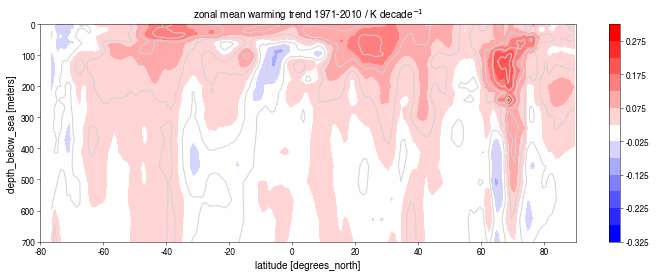

In [9]:
## set scale factor to convert restart pertubration to AR5F3.1 units
scale_factor = (AWI.loc[2010]-AWI.loc[1971].mean()) / (AWI.loc[2022]-AWI.loc[1850:1900].mean()) / 4

p=(t3d_zonmean*scale_factor).squeeze().plot.contourf(levels=np.linspace(-0.325,0.325,14),extend='neither',cmap='bwr',add_colorbar=True,figsize=(12,4))
(t3d_zonmean*scale_factor).squeeze().plot.contour(levels=np.linspace(-0.3,0.3,13),colors='lightgrey',add_colorbar=False)

plt.ylim(700,0)
plt.xlim(-80,90)
plt.title('zonal mean warming trend 1971-2010 / K decade$^{-1}$')

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 0.4
fig.set_size_inches(textwidth,textwidth*aspect)
fig.tight_layout()
fig.dpi=150

Sea ice concentration trend (1979-2014)

Refs:

Lee, S.-K., Volkov, D. L., Lopez, H., Cheon, W. G., Gordon, A. L., Liu, Y., & Wanninkhof, R. (2017). Wind-driven ocean dynamics impact on the contrasting sea-ice trends around West Antarctica. Journal of Geophysical Research: Oceans, 122(5), 4413–4430. https://doi.org/10.1002/2016JC012416

In [10]:
sic_remap = xr.open_dataset(cdo.remapbil('r720x360',input='-ifthen -sellevidx,1 -selvar,tmask /gf3/predict2/AWH009_LEACH_RELIABLE/COUNTERFACTUAL-FORECASTING/IC-prep/mesh_masks/ORCA025_Z75_v1/mesh_mask.nc '+outdir+'tmp/sic_remap.nc'))

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


''

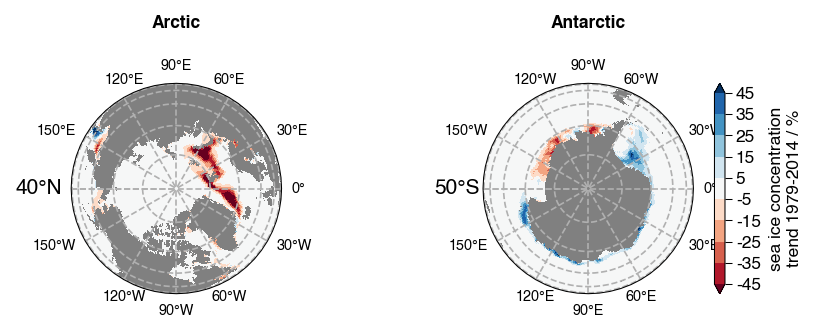

In [26]:
sic_trend_cmap = copy(matplotlib.cm.RdBu)
sic_trend_cmap.set_bad(color='grey')

scale_factor = 100 * (AWI.loc[2014]-AWI.loc[1979].mean()) / (AWI.loc[2022]-AWI.loc[1850:1900].mean())

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1,2)

ax = [fig.add_subplot(gs[i],projection=crs.NearsidePerspective(central_longitude=-90,central_latitude=x,satellite_height=5000000)) for i,x in enumerate([90,-90])]

p=(sic_remap*scale_factor).ileadfra.plot(ax=ax[0],transform=crs.PlateCarree(),add_colorbar=False,levels=np.linspace(-45,45,10),cmap=sic_trend_cmap,extend='both')
p=(sic_remap*scale_factor).ileadfra.plot(ax=ax[1],transform=crs.PlateCarree(),add_colorbar=False,levels=np.linspace(-45,45,10),cmap=sic_trend_cmap,extend='both')

axins = inset_axes(ax[1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.1, 0.00, 1, 1),bbox_transform=ax[1].transAxes,borderpad=0)
cbar=plt.colorbar(p,cax=axins)
axins.set_ylabel('sea ice concentration\ntrend 1979-2014 / %',fontsize='small')

ax[0].set_title('Arctic',pad=15,fontsize='small',fontweight='bold',)
ax[1].set_title('Antarctic',pad=15,fontsize='small',fontweight='bold')

gl = [ax[0].gridlines(draw_labels=True,xlocs=np.arange(-180,181,30),linestyle='--')]
gl += [ax[1].gridlines(draw_labels=True,xlocs=np.arange(-180,181,30),linestyle='--')]

for gl0 in gl:
    gl0.xlabel_style= dict(size='x-small')

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 0.4
fig.set_size_inches(textwidth,textwidth*aspect)
gs.tight_layout(fig,w_pad=0)
fig.dpi=150
''

Sea ice thickness trend (1979-2014)

Refs:

Massonnet, F., Mathiot, P., Fichefet, T., Goosse, H., König Beatty, C., Vancoppenolle, M., & Lavergne, T. (2013). A model reconstruction of the Antarctic sea ice thickness and volume changes over 1980–2008 using data assimilation. Ocean Modelling, 64, 67–75. https://doi.org/10.1016/j.ocemod.2013.01.003

Lindsay, R., & Schweiger, A. (2015). Arctic sea ice thickness loss determined using subsurface, aircraft, and satellite observations. The Cryosphere, 9(1), 269–283. https://doi.org/10.5194/tc-9-269-2015

In [12]:
sit_remap = xr.open_dataset(cdo.remapbil('r720x360',input='-ifthen -sellevidx,1 -selvar,tmask /gf3/predict2/AWH009_LEACH_RELIABLE/COUNTERFACTUAL-FORECASTING/IC-prep/mesh_masks/ORCA025_Z75_v1/mesh_mask.nc '+outdir+'tmp/sit_remap.nc'))

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


''

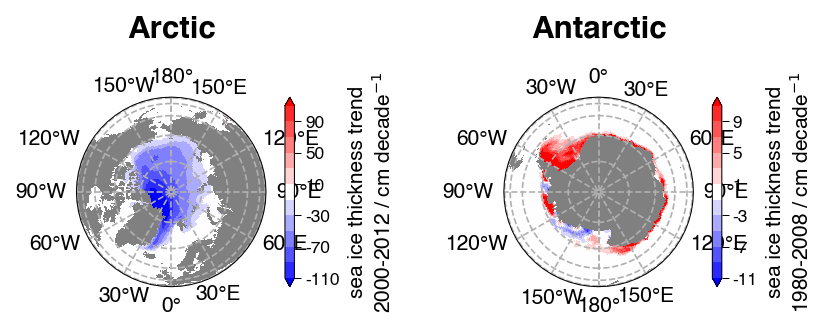

In [14]:
sit_trend_cmap = copy(matplotlib.cm.bwr)
sit_trend_cmap.set_bad(color='grey')

scale_factor = (AWI.loc[2012]-AWI.loc[2000].mean()) / (AWI.loc[2022]-AWI.loc[1850:1900].mean()) / 1.2 * 100

fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1,2,wspace=0.5)

ax = [fig.add_subplot(gs[i],projection=crs.NearsidePerspective(central_longitude=0,central_latitude=x,satellite_height=5000000)) for i,x in enumerate([90,-90])]

p=(sit_remap*scale_factor).iicethic.plot(ax=ax[0],transform=crs.PlateCarree(),add_colorbar=False,levels=np.linspace(-110,110,12),cmap=sit_trend_cmap,extend='both')

axins = inset_axes(ax[0], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.1, 0.00, 1, 1),bbox_transform=ax[0].transAxes,borderpad=0)
cbar=plt.colorbar(p,cax=axins)
axins.set_ylabel('sea ice thickness trend\n2000-2012 / cm decade$^{-1}$')

scale_factor = (AWI.loc[2008]-AWI.loc[1980].mean()) / (AWI.loc[2022]-AWI.loc[1850:1900].mean()) / 2.8 * 100

p=(sit_remap*scale_factor).iicethic.plot(ax=ax[1],transform=crs.PlateCarree(),add_colorbar=False,levels=np.linspace(-11,11,12),cmap=sit_trend_cmap,extend='both')

axins = inset_axes(ax[1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.1, 0.00, 1, 1),bbox_transform=ax[1].transAxes,borderpad=0)
cbar=plt.colorbar(p,cax=axins)
axins.set_ylabel('sea ice thickness trend\n1980-2008 / cm decade$^{-1}$')


ax[0].set_title('Arctic',pad=15,fontsize=15,fontweight='bold')
ax[1].set_title('Antarctic',pad=15,fontsize=15,fontweight='bold')

ax[0].gridlines(draw_labels=True,xlocs=np.arange(-180,181,30),linestyle='--')
ax[1].gridlines(draw_labels=True,xlocs=np.arange(-180,181,30),linestyle='--')

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 0.4
fig.set_size_inches(textwidth,textwidth*aspect)
gs.tight_layout(fig)
fig.dpi=150
''